In [1]:
from matplotlib import pyplot as plt

import numpy as np
import cv2 as cv

In [2]:
filename = './videos/gray/selena.avi'

In [3]:
def diff_pixels(frameA, frameB, params):
    diff = np.abs(frameA - frameB)
    return np.where(diff > params[0], 1, 0).sum()


In [4]:
def reshape(image, size):
    height, width = image.shape

    tiled_array = image.reshape(height // size, size, width // size, size)
    tiled_array = tiled_array.swapaxes(1, 2).reshape(-1, size, size)
    return tiled_array


def diff_blocks(frameA, frameB, params):
    diff = np.abs(frameA - frameB)
    diff = diff * diff

    rows, cols = frameA.shape
    trows = rows // params[0]
    tcols = cols // params[0]

    diff = diff[:trows * params[0], :tcols * params[0]]

    difference = np.sum(reshape(diff, params[0]), axis=(1, 2))
    return (np.sqrt(difference) > params[2]).sum()


In [5]:
def diff_histogram(frameA, frameB, params):
    histA, _ = np.histogram(frameA, bins=256, range=(0, 255))
    histB, _ = np.histogram(frameB, bins=256, range=(0, 255))

    diff = np.abs(histA - histB)
    mean = diff.mean()
    std = diff.std()

    return mean + std*3


In [6]:
def normalize(img_in):
    img_out = np.zeros(img_in.shape, dtype="uint8")

    tmin = img_in.min()
    tmax = img_in.max()

    tsize = abs(tmax - tmin)
    img_out = ((img_in - tmin) * 255) // tsize
    return img_out


def sobelX(img_in):
    res_h = img_in[:, 2:] - img_in[:, :-2]
    res_v = res_h[:-2] + res_h[2:] + 2*res_h[1:-1]
    return np.abs(res_v)


def sobelY(img_in):
    img = img_in.transpose()
    res_h = img[:, 2:] - img[:, :-2]
    res_v = res_h[:-2] + res_h[2:] + 2*res_h[1:-1]
    return np.abs(res_v.transpose())


def sobel(img):
    img = img.astype('int16')
    out = np.zeros(img.shape, int)
    x = sobelX(img)
    y = sobelY(img)

    out[1:-1, 1:-1] = x + y

    return out


def diff_edges(frameA, frameB, params):
    maskA = normalize(sobel(frameA))
    return (maskA > params[0]).sum()


In [7]:
def get_metrics(file, difference, params, dtype='int16'):
    cap = cv.VideoCapture(file)

    metrics = []

    ret, frame = cap.read()

    old_frame = frame[:, :, 0].astype(dtype)
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret:
            gray_frame = frame[:, :, 0].astype(dtype)
            metrics.append(difference(gray_frame, old_frame, params))
            old_frame = gray_frame
        else:
            cap.release()
            break

    return metrics


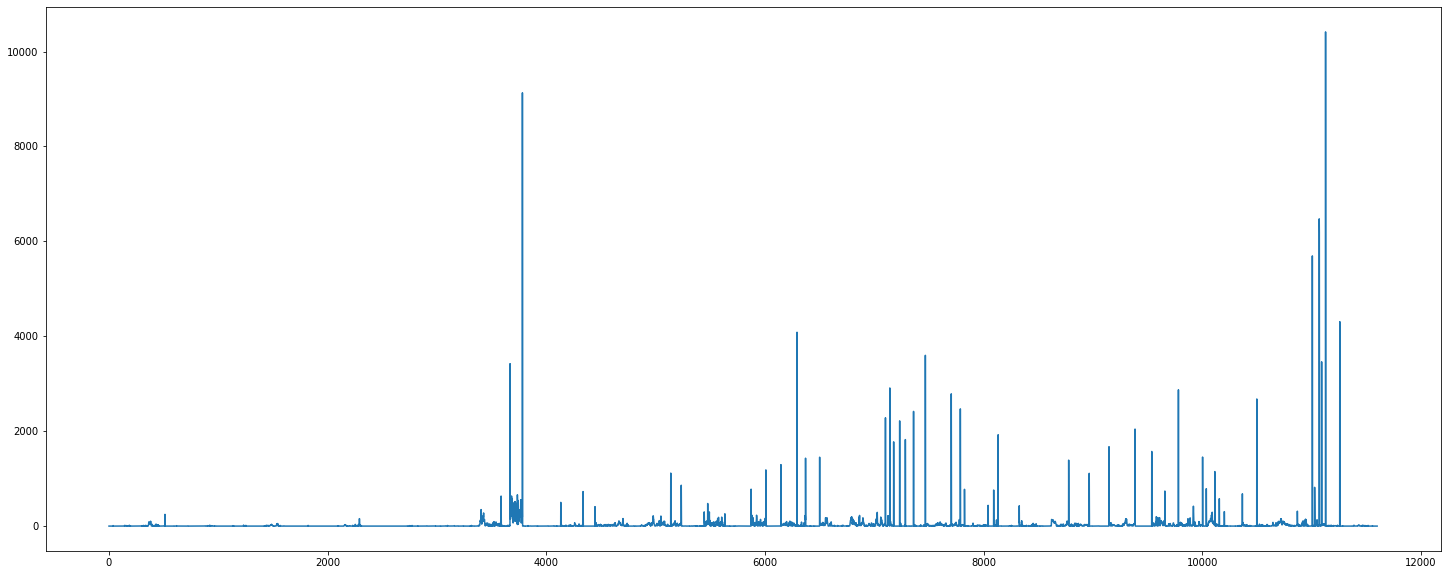

In [8]:
Y = np.array(get_metrics(filename, diff_pixels, [128]))
X = range(len(Y))

plt.figure(figsize=(25,10))
plt.plot(X, Y)

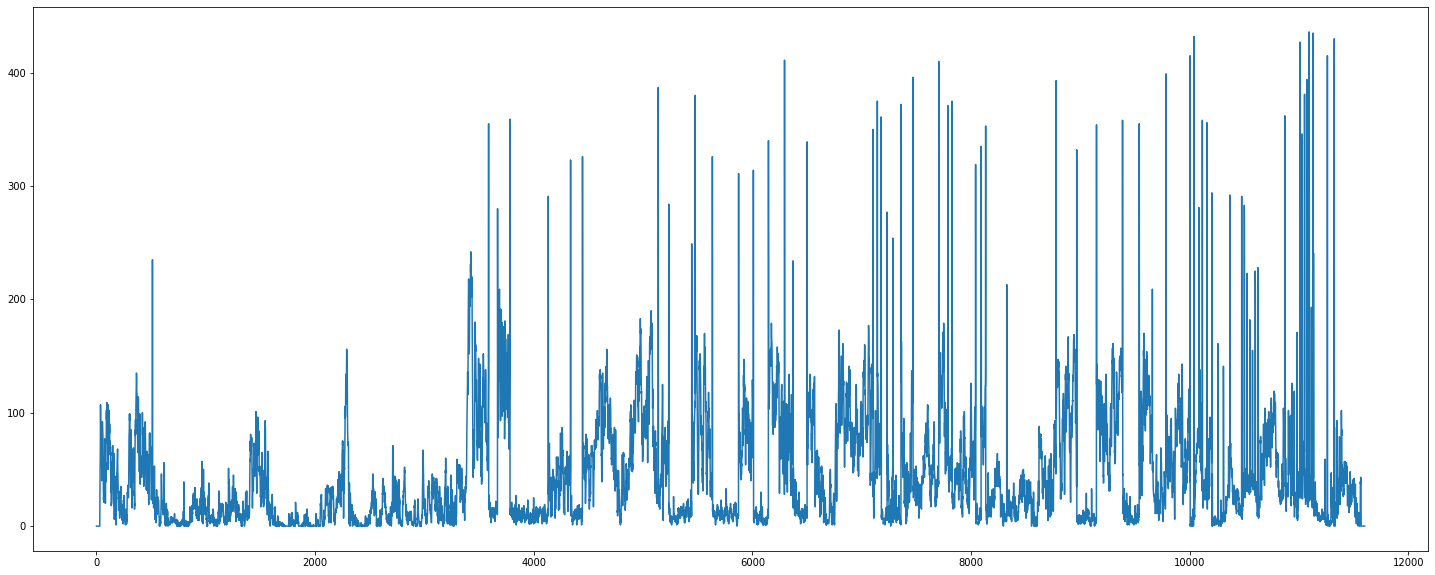

In [9]:
Y = np.array(get_metrics(filename,diff_blocks, [8, 64, 128], 'int32'))
X = range(len(Y))

plt.figure(figsize=(25, 10))
plt.plot(X, Y)

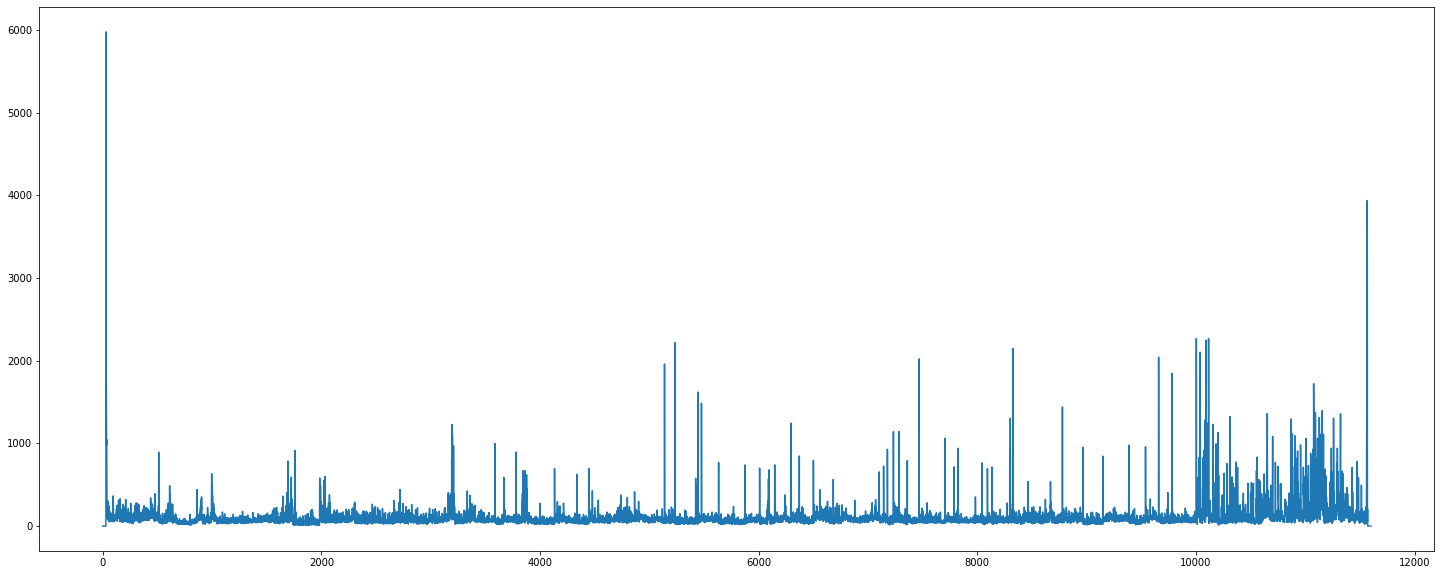

In [10]:
Y = np.array(get_metrics(filename,diff_histogram, []))
X = range(len(Y))

plt.figure(figsize=(25, 10))
plt.plot(X, Y)

/tmp/ipykernel_14558/3618311024.py:8: RuntimeWarning: divide by zero encountered in floor_divide
  img_out = ((img_in - tmin) * 255) // tsize


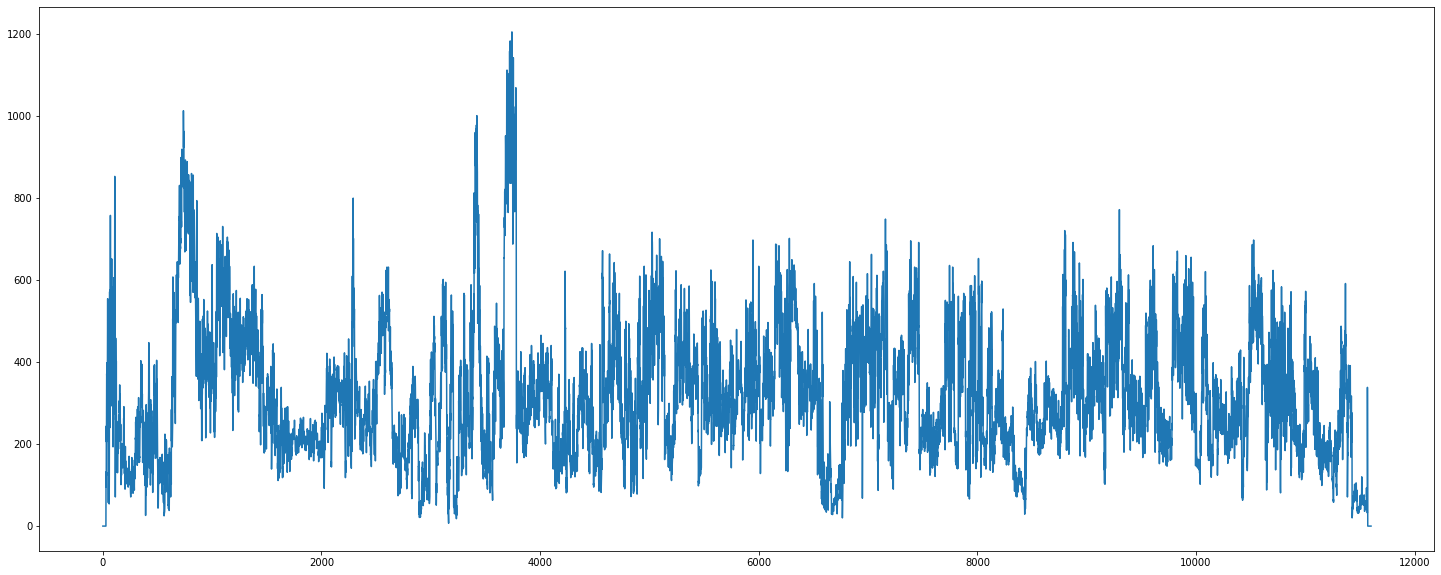

In [11]:
Y = np.array(get_metrics(filename, diff_edges, [128]))
X = range(len(Y))

plt.figure(figsize=(25, 10))
plt.plot(X, Y)
